<a href="https://colab.research.google.com/github/diane-park/TableSnap/blob/main/Table_Detection_Milestone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Dataset

The dataset that we are using is the [General Table Detection Dataset](https://www.kaggle.com/datasets/rhtsingh/general-table-recognition-dataset/data?select=train.csv).
 This dataset contains scanned documents including one or more tables and comes with corresponding table annotations which give bounding box coordinates of the table within the image. This dataset will be downloaded off of Kaggle.

## Accessing the Dataset and Installing Dependencies

Creating a requirements.txt file will help ensure consistency when running this code from another machine.

In [1]:
# Create a requirements.txt file
requirements = """
kagglehub
pandas==1.5.3
torch==2.7.0+cu126
opencv-python==4.5.3.56
matplotlib==3.5.1
git+https://github.com/ultralytics/yolov5.git
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)

# Install dependencies
!pip install -U -r requirements.txt

  Cloning https://github.com/ultralytics/yolov5.git to /tmp/pip-req-build-i58izlyr
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov5.git /tmp/pip-req-build-i58izlyr
  Resolved https://github.com/ultralytics/yolov5.git to commit a493afe1486639b6f542c69716d131bd103ceeef
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


## Download General Table Detection Dataset

In [2]:
# necessary imorts
import kagglehub
import os
import shutil

In [3]:
# Download latest version of dataset
path = kagglehub.dataset_download("rhtsingh/general-table-recognition-dataset")

print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: /kaggle/input/general-table-recognition-dataset


['train_folds.csv',
 'Orig_Annotations-20220104T075522Z-001',
 'create_folds.py',
 'Orig_Image-20220104T074306Z-001',
 'train_annotated.csv',
 'General Dataset-20220104T073035Z-001',
 'train.csv']

## Data Cleansing

As part of our data cleansing, we will first pull relevant information about the informations from the annotation and folds csv files that come with the dataset.

As to

In [4]:
import pandas as pd

annotations_file_path = path + '/train_annotated.csv'
folds_file_path = path + '/train_folds.csv'

# Pull information from annotations and folds csv files
annotations = pd.read_csv(annotations_file_path)
folds = pd.read_csv(folds_file_path)

print(annotations.head())
print(folds.head())

   image_id                    bbox  \
0  0101_003  [769, 945, 1301, 2028]   
1  0110_099  [269, 1652, 2022, 980]   
2  0113_013                     NaN   
3  0140_007  [698, 1781, 1083, 290]   
4  0146_281  [703, 431, 1041, 1121]   

                                       segmentation       area  height  \
0    [[769, 945, 769, 2973, 2070, 2973, 2070, 945]]  2638428.0  3300.0   
1  [[269, 1652, 269, 2632, 2291, 2632, 2291, 1652]]  1981560.0  3300.0   
2                                               NaN        NaN     NaN   
3  [[698, 1781, 698, 2071, 1781, 2071, 1781, 1781]]   314070.0  3300.0   
4    [[703, 431, 703, 1552, 1744, 1552, 1744, 431]]  1166961.0  3300.0   

    width  bbox_xmin  bbox_ymin  bbox_width  bbox_height  
0  2544.0      769.0      945.0      1301.0       2028.0  
1  2544.0      269.0     1652.0      2022.0        980.0  
2     NaN        NaN        NaN         NaN          NaN  
3  2560.0      698.0     1781.0      1083.0        290.0  
4  2544.0      703.0     

In [5]:
# filtering for images with a single datatables
folds_filtered = folds[folds["bbox_count"] == 1]
print(folds_filtered.head())

   image_id  bbox_count  source  fold
0  0101_003           1  marmot     3
1  0110_099           1  marmot     0
2  0140_007           1  marmot     4
7  0148_271           1  marmot     1
8  0148_479           1  marmot     2


In [6]:
# continuing filtering for single datatables using annotated dataset
# only need annotations_filtered now, don't need to use folds
valid_image_ids = set(folds_filtered["image_id"])

annotations_filtered = annotations[annotations["image_id"].isin(valid_image_ids)].copy()

print(annotations_filtered.head())
print(annotations_filtered.shape)

    image_id                    bbox  \
0   0101_003  [769, 945, 1301, 2028]   
1   0110_099  [269, 1652, 2022, 980]   
3   0140_007  [698, 1781, 1083, 290]   
12  0148_271  [389, 383, 1766, 1032]   
13  0148_479  [932, 425, 1198, 1081]   

                                        segmentation       area  height  \
0     [[769, 945, 769, 2973, 2070, 2973, 2070, 945]]  2638428.0  3300.0   
1   [[269, 1652, 269, 2632, 2291, 2632, 2291, 1652]]  1981560.0  3300.0   
3   [[698, 1781, 698, 2071, 1781, 2071, 1781, 1781]]   314070.0  3300.0   
12    [[389, 383, 389, 1415, 2155, 1415, 2155, 383]]  1822512.0  3300.0   
13    [[932, 425, 932, 1506, 2130, 1506, 2130, 425]]  1295038.0  3300.0   

     width  bbox_xmin  bbox_ymin  bbox_width  bbox_height  
0   2544.0      769.0      945.0      1301.0       2028.0  
1   2544.0      269.0     1652.0      2022.0        980.0  
3   2560.0      698.0     1781.0      1083.0        290.0  
12  2544.0      389.0      383.0      1766.0       1032.0  
13  2560

In [7]:
# Rescale bbox values to be in terms of the image width and height instead of pixel value
# This will lead to less issues when resizing images during the data loading

scaled_bboxes = []
for index, row in annotations_filtered.iterrows():
  x_min = row['bbox_xmin']
  y_min = row['bbox_ymin']
  bbox_width = row['bbox_width']
  bbox_height = row['bbox_height']

  im_width= row["width"]
  im_height = row["height"]

  # All bbox values are now from 0 to 1
  bbox = [x_min/im_width, y_min/im_height, bbox_width/im_width, bbox_height/im_height]

  scaled_bboxes.append(bbox)

In [8]:
# Declare X and Y variables
X = annotations_filtered["image_id"].to_list()
Y = scaled_bboxes

# Check we have the same number of inputs and labels
print("Number of samples in X: ", len(X))
print("Number of samples in Y: ", len(Y))

Number of samples in X:  1308
Number of samples in Y:  1308


## Data Processing
Create 70/20/10 train/val/test splits

In [9]:
# Total number of samples
total_samples = len(X)

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the indices for splitting
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = int(total_samples * test_ratio)

# Split the data dynamically
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

print("Number of samples in train set: ", len(X_train))
print("Number of samples in val set: ", len(X_val))
print("Number of samples in test set: ", len(X_test))

Number of samples in train set:  915
Number of samples in val set:  261
Number of samples in test set:  132


In [10]:
# Target YOLO-style structure
target_train_image_dir = 'dataset/images/train'
target_train_label_dir = 'dataset/labels/train'

target_val_image_dir = 'dataset/images/val'
target_val_label_dir = 'dataset/labels/val'

target_test_image_dir = 'dataset/images/test'
target_test_label_dir = 'dataset/labels/test'


# create the directories to write to later
os.makedirs(target_train_image_dir, exist_ok=True)
os.makedirs(target_train_label_dir, exist_ok=True)
os.makedirs(target_val_image_dir, exist_ok=True)
os.makedirs(target_val_label_dir, exist_ok=True)
os.makedirs(target_test_image_dir, exist_ok=True)
os.makedirs(target_test_label_dir, exist_ok=True)

In [18]:
import cv2

def process_data(ids, bboxes, target_image_dir, target_label_dir):
    for id, bbox in zip(ids, bboxes):
        # Determine which image file to copy (PNG or JPG)
        if os.path.exists(path + '/Orig_Image-20220104T074306Z-001/Orig_Image/' + id + '.png'):
            img = cv2.imread(path + '/Orig_Image-20220104T074306Z-001/Orig_Image/' + id + '.png')
        else:
            img = cv2.imread(path + '/Orig_Image-20220104T074306Z-001/Orig_Image/' + id + '.jpg')

        # Create label file
        new_file = target_label_dir + '/' + id + '.txt'

        # Calculate bounding box in YOLO format (x_center, y_center, width, height)
        x_center = bbox[0] + bbox[2]/2
        y_center = bbox[1] + bbox[3]/2
        width = bbox[2]
        height = bbox[3]

        # Write the label file
        with open(new_file, "w") as file:
            file.write(f"0 {x_center} {y_center} {width} {height}")

# TEST
process_data(X_test, Y_test, target_test_image_dir, target_test_label_dir)

# VALIDATION
process_data(X_val, Y_val, target_val_image_dir, target_val_label_dir)

# TRAIN
process_data(X_train, Y_train, target_train_image_dir, target_train_label_dir)

## Baseline Model

We will use YOLOv5 as our baseline model for obejct detection. We thought YOLO would be a good baseline because it pads images for you and resizes them so we can have images of different sizes.

In [19]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -U -r requirements.txt

import torch
print(torch.cuda.is_available())  # Should print True if GPU is available

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5/yolov5
True


In [20]:
# Create data.yaml file

data_yaml_content = """
train: /content/dataset/images/train
val: /content/dataset/images/val
test: /content/dataset/images/test

nc: 1
names: ['datatables']
"""

# Specify the path where to save the data.yaml file
data_yaml_path = '/content/data.yaml'

# Write the content to the data.yaml file
with open(data_yaml_path, 'w') as file:
    file.write(data_yaml_content)

print(f"data.yaml file created at {data_yaml_path}")

data.yaml file created at /content/data.yaml


You will have the option to enter your W&B account in order to visualize results. Please input your account info, if possible.

Please use a GPU to accelerate the training. In Colab, you can enable this in **Runtime** -> **Change Runtime Type** -> Under **Hardware accelerator**, select **GPU** -> Save

In [21]:
# train from the YOLOv5 repo
!python train.py --img 640 --batch 16 --epochs 10 --exist-ok --data /content/data.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolo_model > train.log 2>&1

# evaluate the model
!python val.py --weights runs/train/yolo_model/weights/best.pt --data /content/data.yaml --img 640

val: data=/content/data.yaml, weights=['runs/train/yolo_model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/dataset/labels/val.cache... 262 images, 0 backgrounds, 0 corrupt: 100% 262/262 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 9/9 [00:10<00:00,  1.16s/it]
                   all        262        262      0.886      0.939      0.959      0.755
Speed: 0.6ms pre-process, 5.6ms inference, 4.1ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp


In [30]:
# Save weights to Shared Google Drive after training
from google.colab import drive
drive.mount('/content/drive')

# Create a folder for the model weights
!mkdir -p "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models"

# Copy the trained weights to Drive
!cp runs/train/yolo_model/weights/best.pt "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/baseline_yolo_model_best.pt"

Mounted at /content/drive


In [23]:
# Examine loss, precision, and recall during training
!cat runs/train/yolo_model/results.csv

               epoch,      train/box_loss,      train/obj_loss,      train/cls_loss,   metrics/precision,      metrics/recall,     metrics/mAP_0.5,metrics/mAP_0.5:0.95,        val/box_loss,        val/obj_loss,        val/cls_loss,               x/lr0,               x/lr1,               x/lr2
                   0,            0.099549,            0.028129,                   0,            0.044542,             0.30916,            0.040291,            0.012398,            0.035309,            0.015136,                   0,            0.070517,           0.0032759,           0.0032759
                   1,            0.063244,            0.022786,                   0,             0.51744,             0.60687,             0.61498,             0.29379,            0.026628,           0.0084278,                   0,            0.039863,           0.0059549,           0.0059549
                   2,             0.05436,            0.018433,                   0,             0.47048,             

In [53]:
# Define paths
test_image_dir = 'dataset/images/test'
test_label_dir = 'dataset/labels/test'
# model_weights = 'runs/train/yolo_model/weights/best.pt'
model_weights = "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/baseline_yolo_model_best.pt"

# Load the trained YOLOv5 model (optional, for manual inference or visualizations)
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_weights, trust_repo=True)

# Run YOLOv5's evaluation script on the test set
!python val.py --weights "{model_weights}" --data /content/data.yaml --task test --img 640 --save-json


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-14 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


val: data=/content/data.yaml, weights=['/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/baseline_yolo_model_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/dataset/labels/test.cache... 131 images, 1 backgrounds, 0 corrupt: 100% 132/132 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 5/5 [00:07<00:00,  1.45s/it]
                   all        132        131      0.931      0.927      0.964      0.749
Speed: 2.4ms pre-process, 9.9ms inference, 8.0ms NMS 

In [37]:
# Calculate F1 score
precision = 0.882
recall = 0.924

f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Output
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")

Precision: 0.8820
Recall:    0.9240
F1 Score:  0.9025


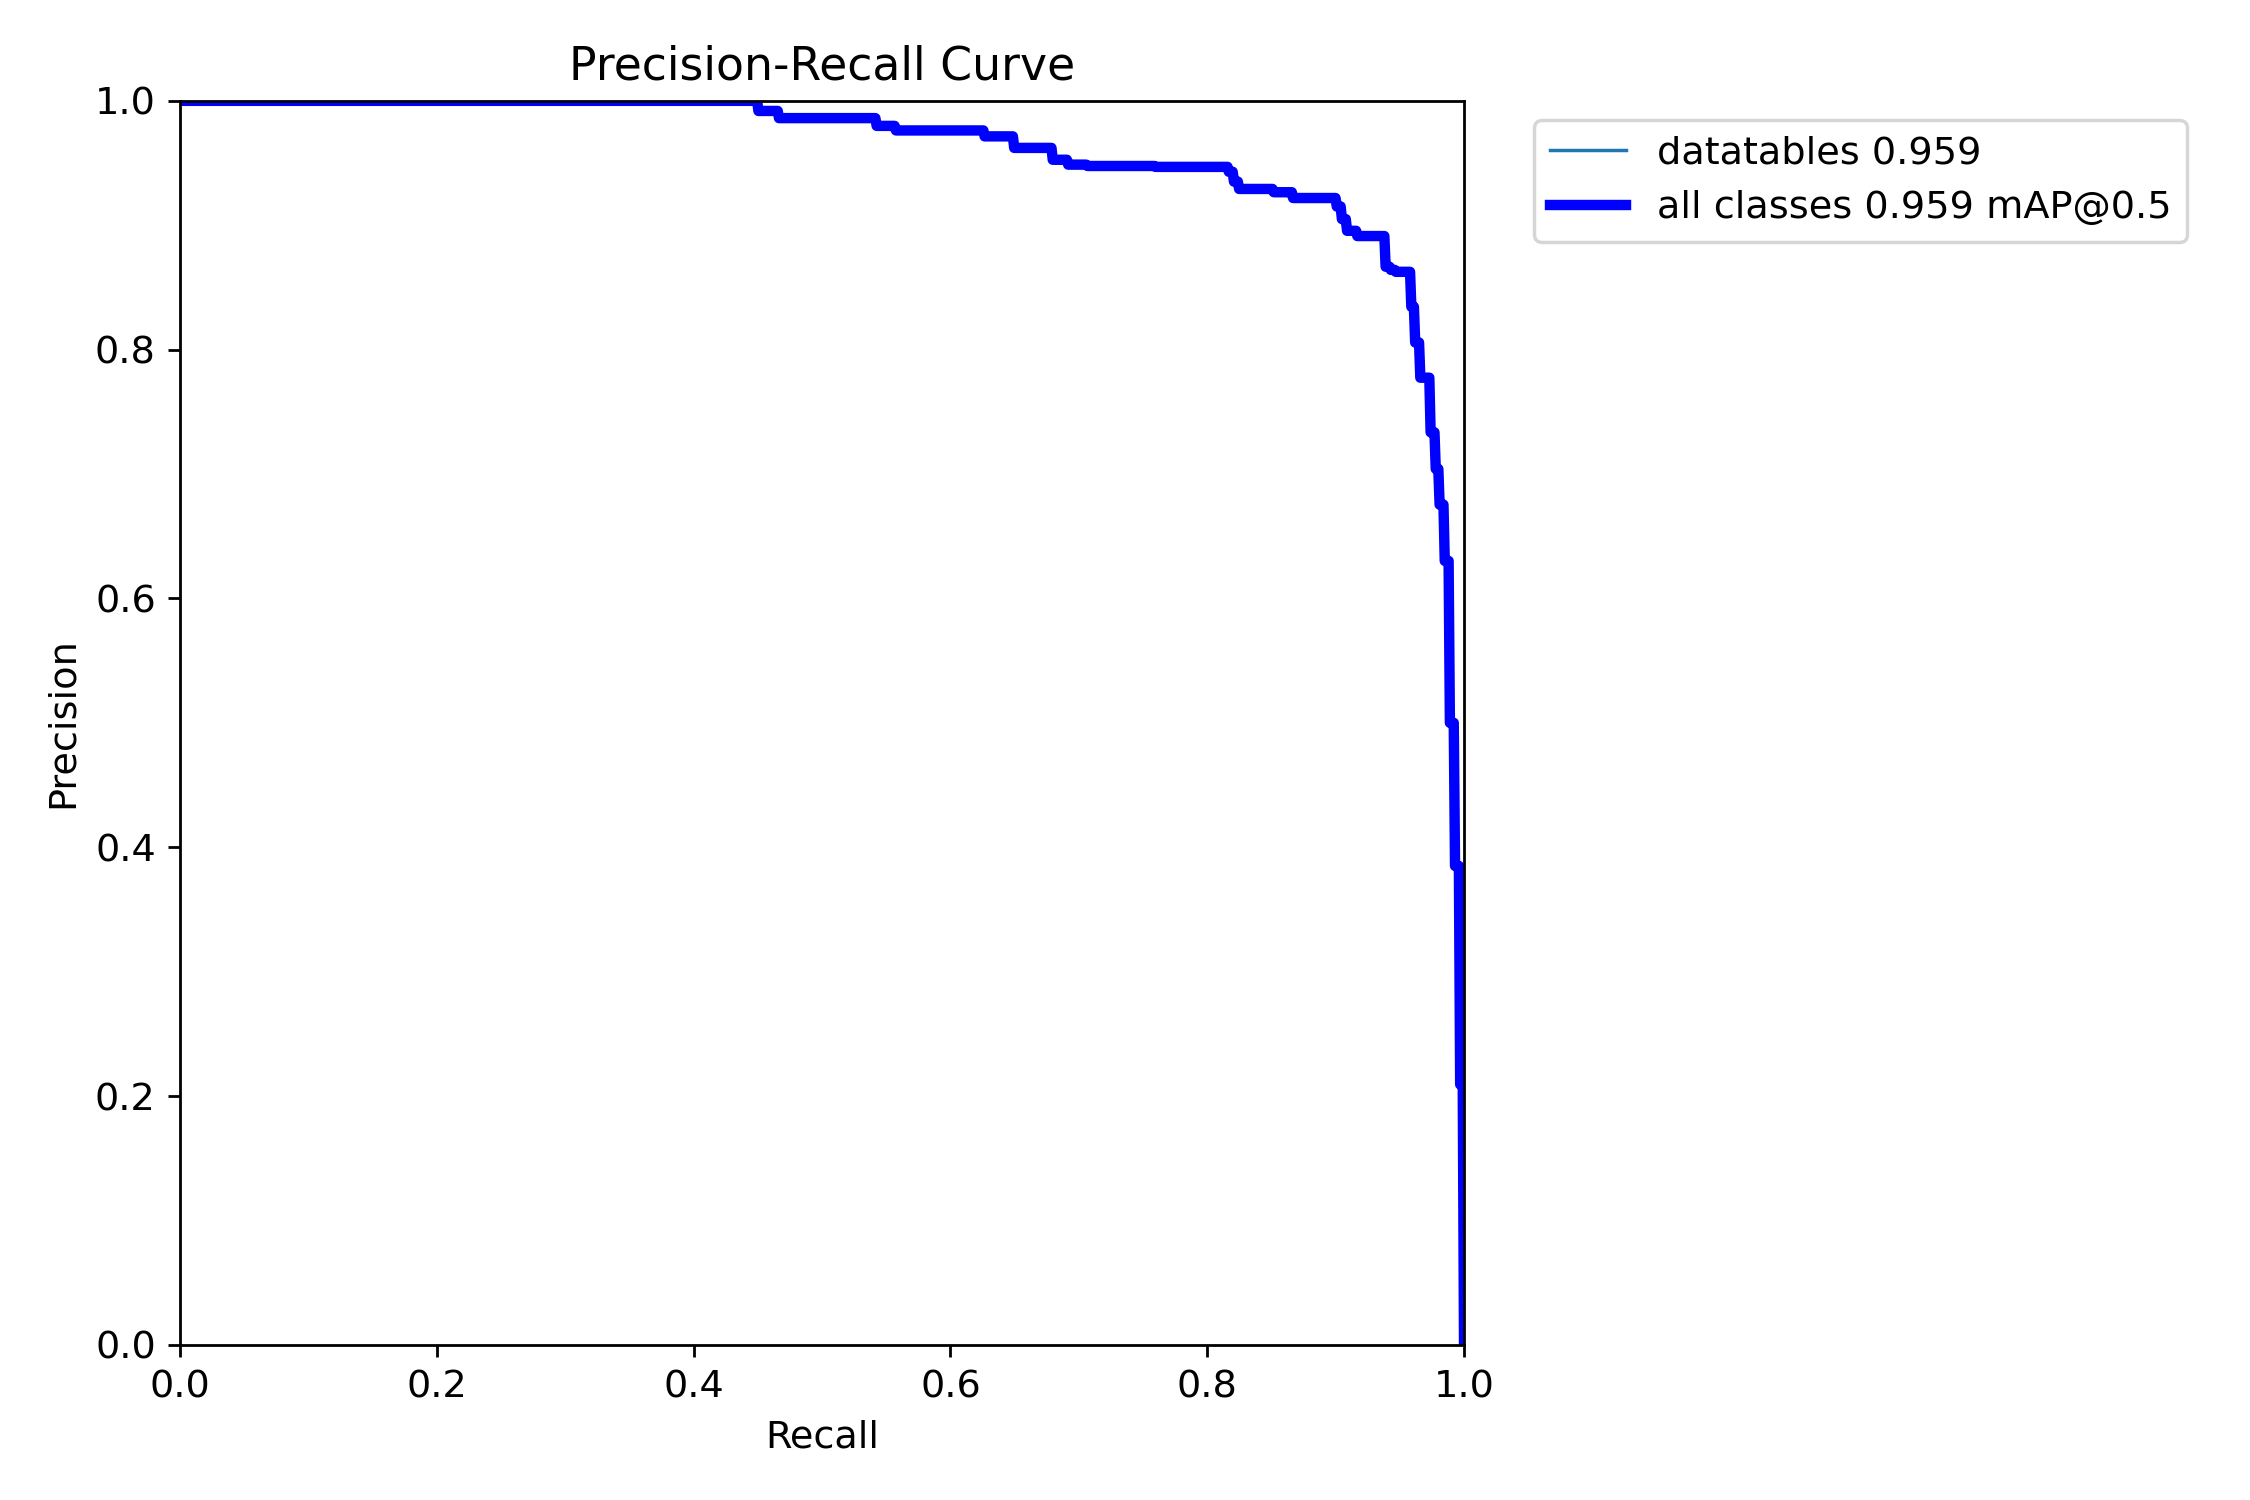

In [80]:
from IPython import display
display.Image("/content/yolov5/yolov5/runs/val/exp/PR_curve.png", width=600) # may have to chang exp number, ran it too many times


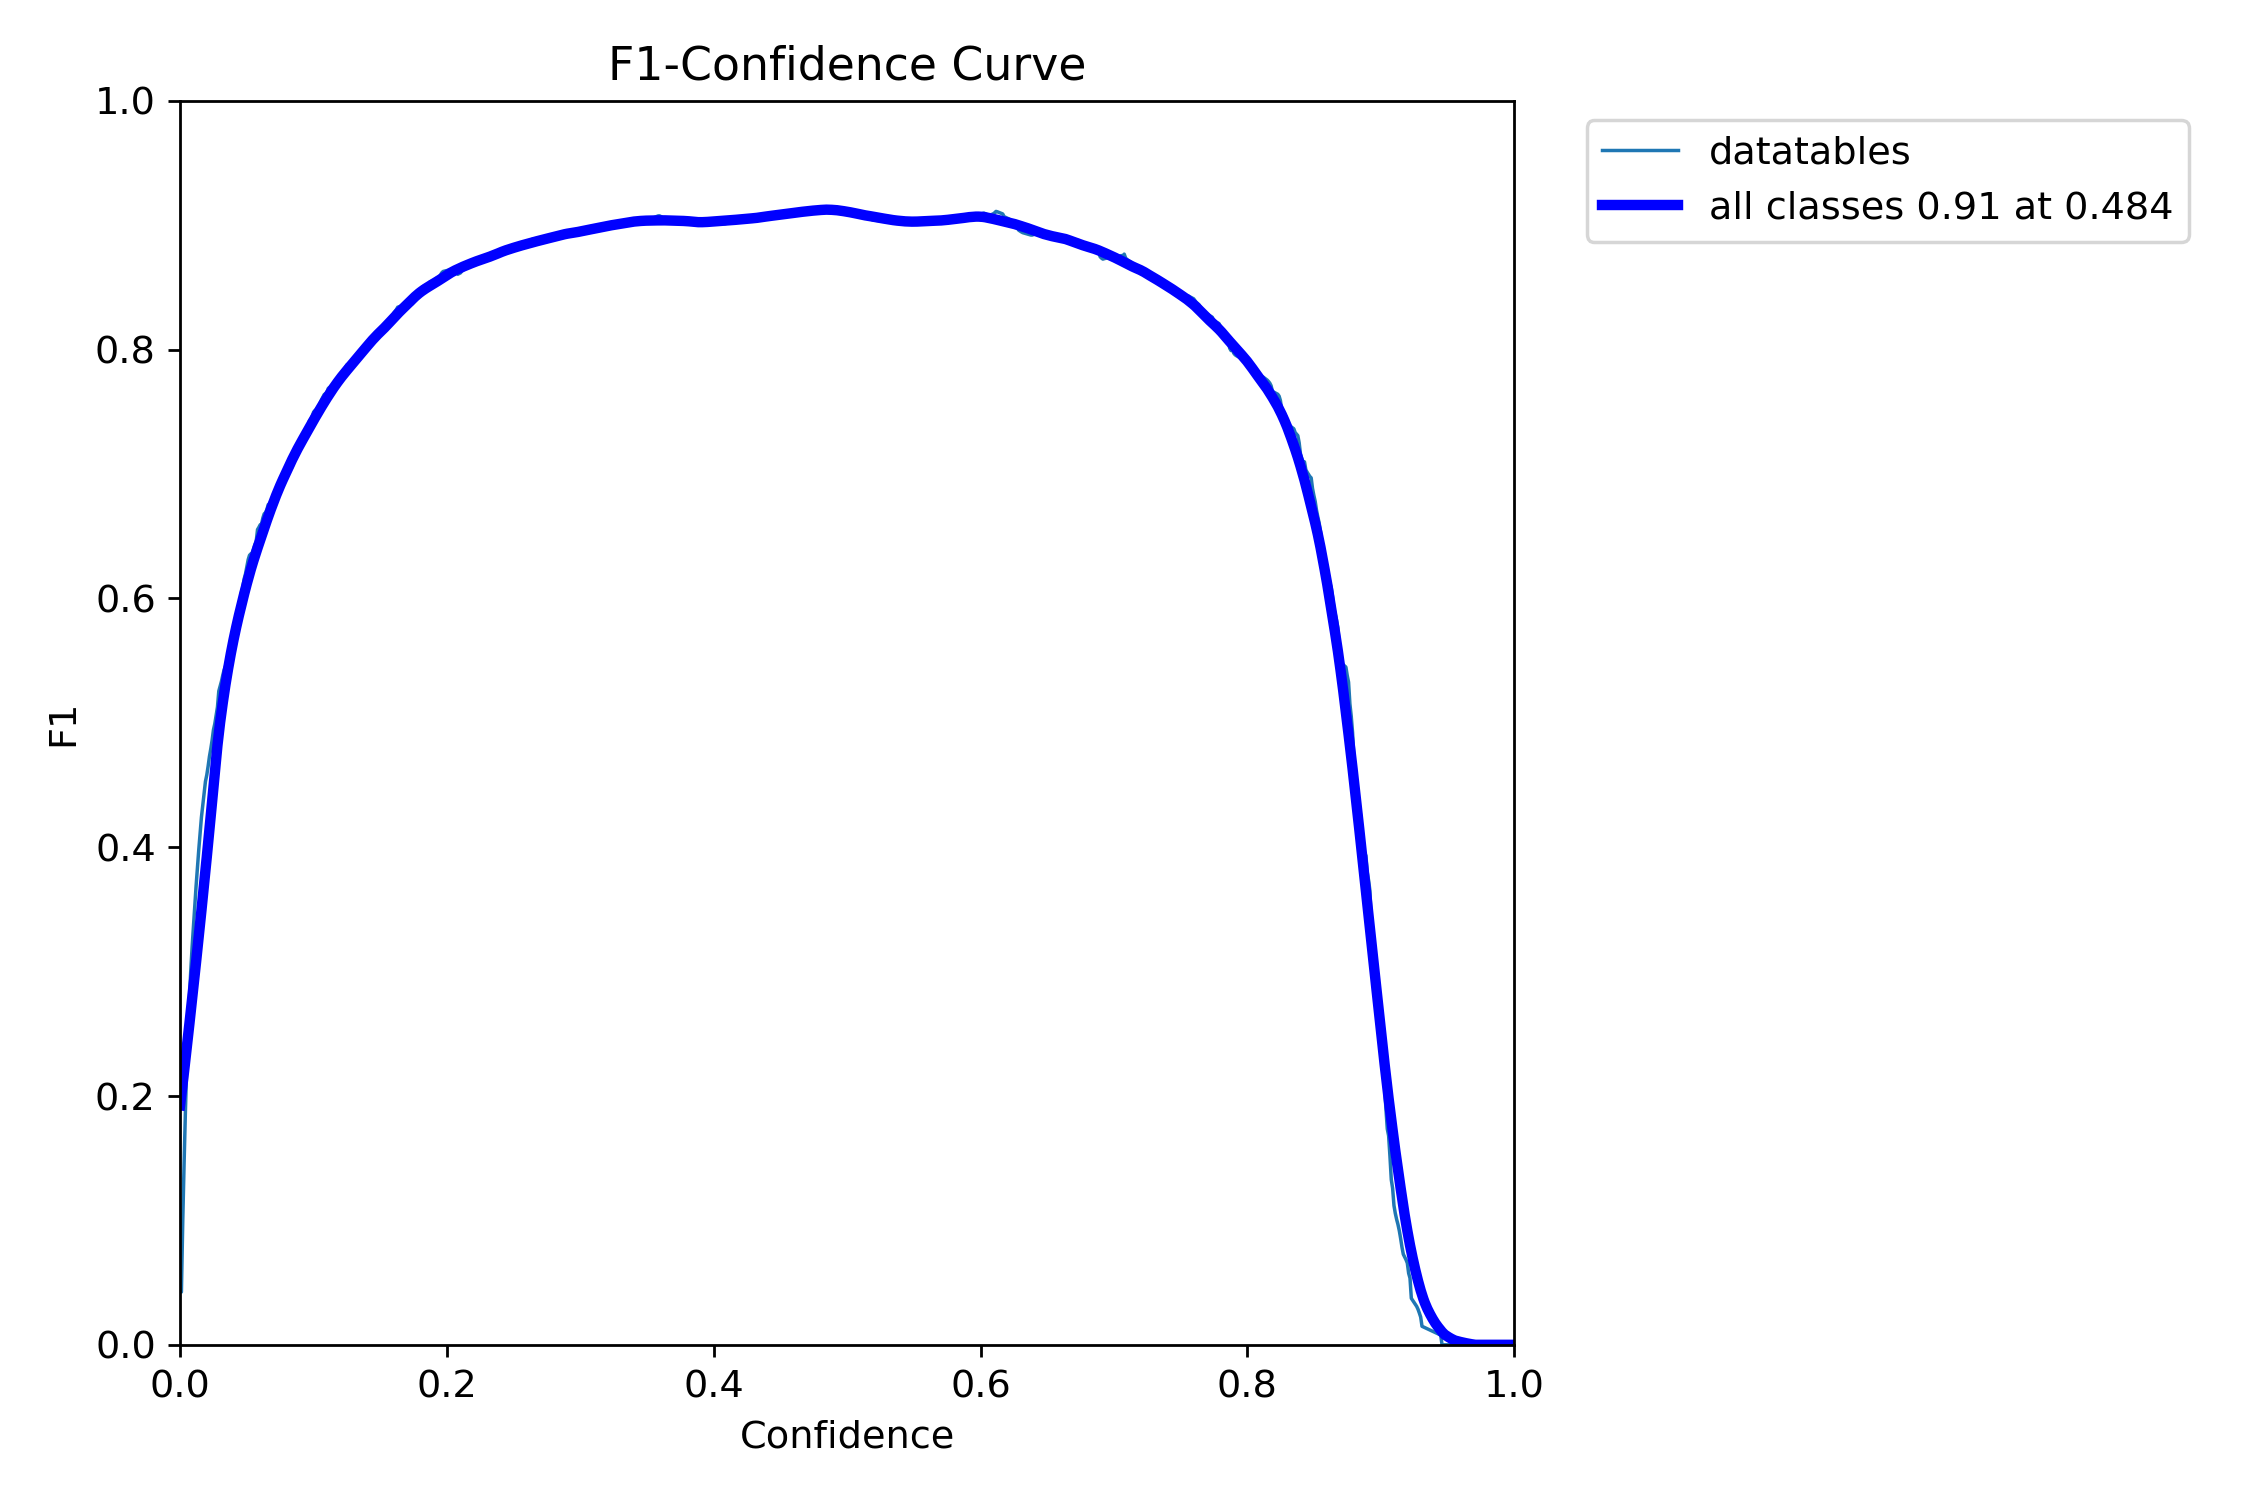

In [81]:
display.Image("/content/yolov5/yolov5/runs/val/exp/F1_curve.png", width=600) # same here about exp number

#Deep Learning Model


In [56]:
# go to the YOLOv5 repo
%cd yolov5

# fine-tune from our baseline model with more epochs, and a lower learning rate
!python train.py --img 640 --batch 16 --epochs 30 --exist-ok --data /content/data.yaml --cfg models/yolov5s.yaml --weights runs/train/yolo_model/weights/best.pt --name fine_tuned_model --hyp data/hyps/hyp.scratch-low.yaml > train.log 2>&1
!python val.py --weights runs/train/fine_tuned_model/weights/best.pt --data /content/data.yaml --img 640


[Errno 2] No such file or directory: 'yolov5'
/content/yolov5/yolov5
val: data=/content/data.yaml, weights=['runs/train/fine_tuned_model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/dataset/labels/val.cache... 262 images, 0 backgrounds, 0 corrupt: 100% 262/262 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 9/9 [00:11<00:00,  1.30s/it]
                   all        262        262      0.896      0.908      0.938      0.762
Speed: 0.2ms pre-process, 7.2ms inference, 3.

In [58]:
# Save weights to Google Drive after training
# Copy the trained weights to Drive
!cp runs/train/fine_tuned_model/weights/best.pt "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/fine_tuned_model_best.pt"

# Evaluation

In [66]:
# Define paths
test_image_dir = 'dataset/images/test'
test_label_dir = 'dataset/labels/test'
model_weights = "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/fine_tuned_model_best.pt"

import torch

# Load the trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_weights, trust_repo=True)

# evaluate model with test images
!python val.py --weights "{model_weights}" --data /content/data.yaml --task test --img 640 --save-json

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-14 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


val: data=/content/data.yaml, weights=['/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/fine_tuned_model_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/dataset/labels/test.cache... 131 images, 1 backgrounds, 0 corrupt: 100% 132/132 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 5/5 [00:06<00:00,  1.27s/it]
                   all        132        131      0.931      0.939      0.957      0.786
Speed: 0.2ms pre-process, 8.5ms inference, 5.3ms NMS per

In [60]:
# Calculate F1 score
precision = 0.926
recall = 0.969
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Output
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")

Precision: 0.9260
Recall:    0.9690
F1 Score:  0.9470


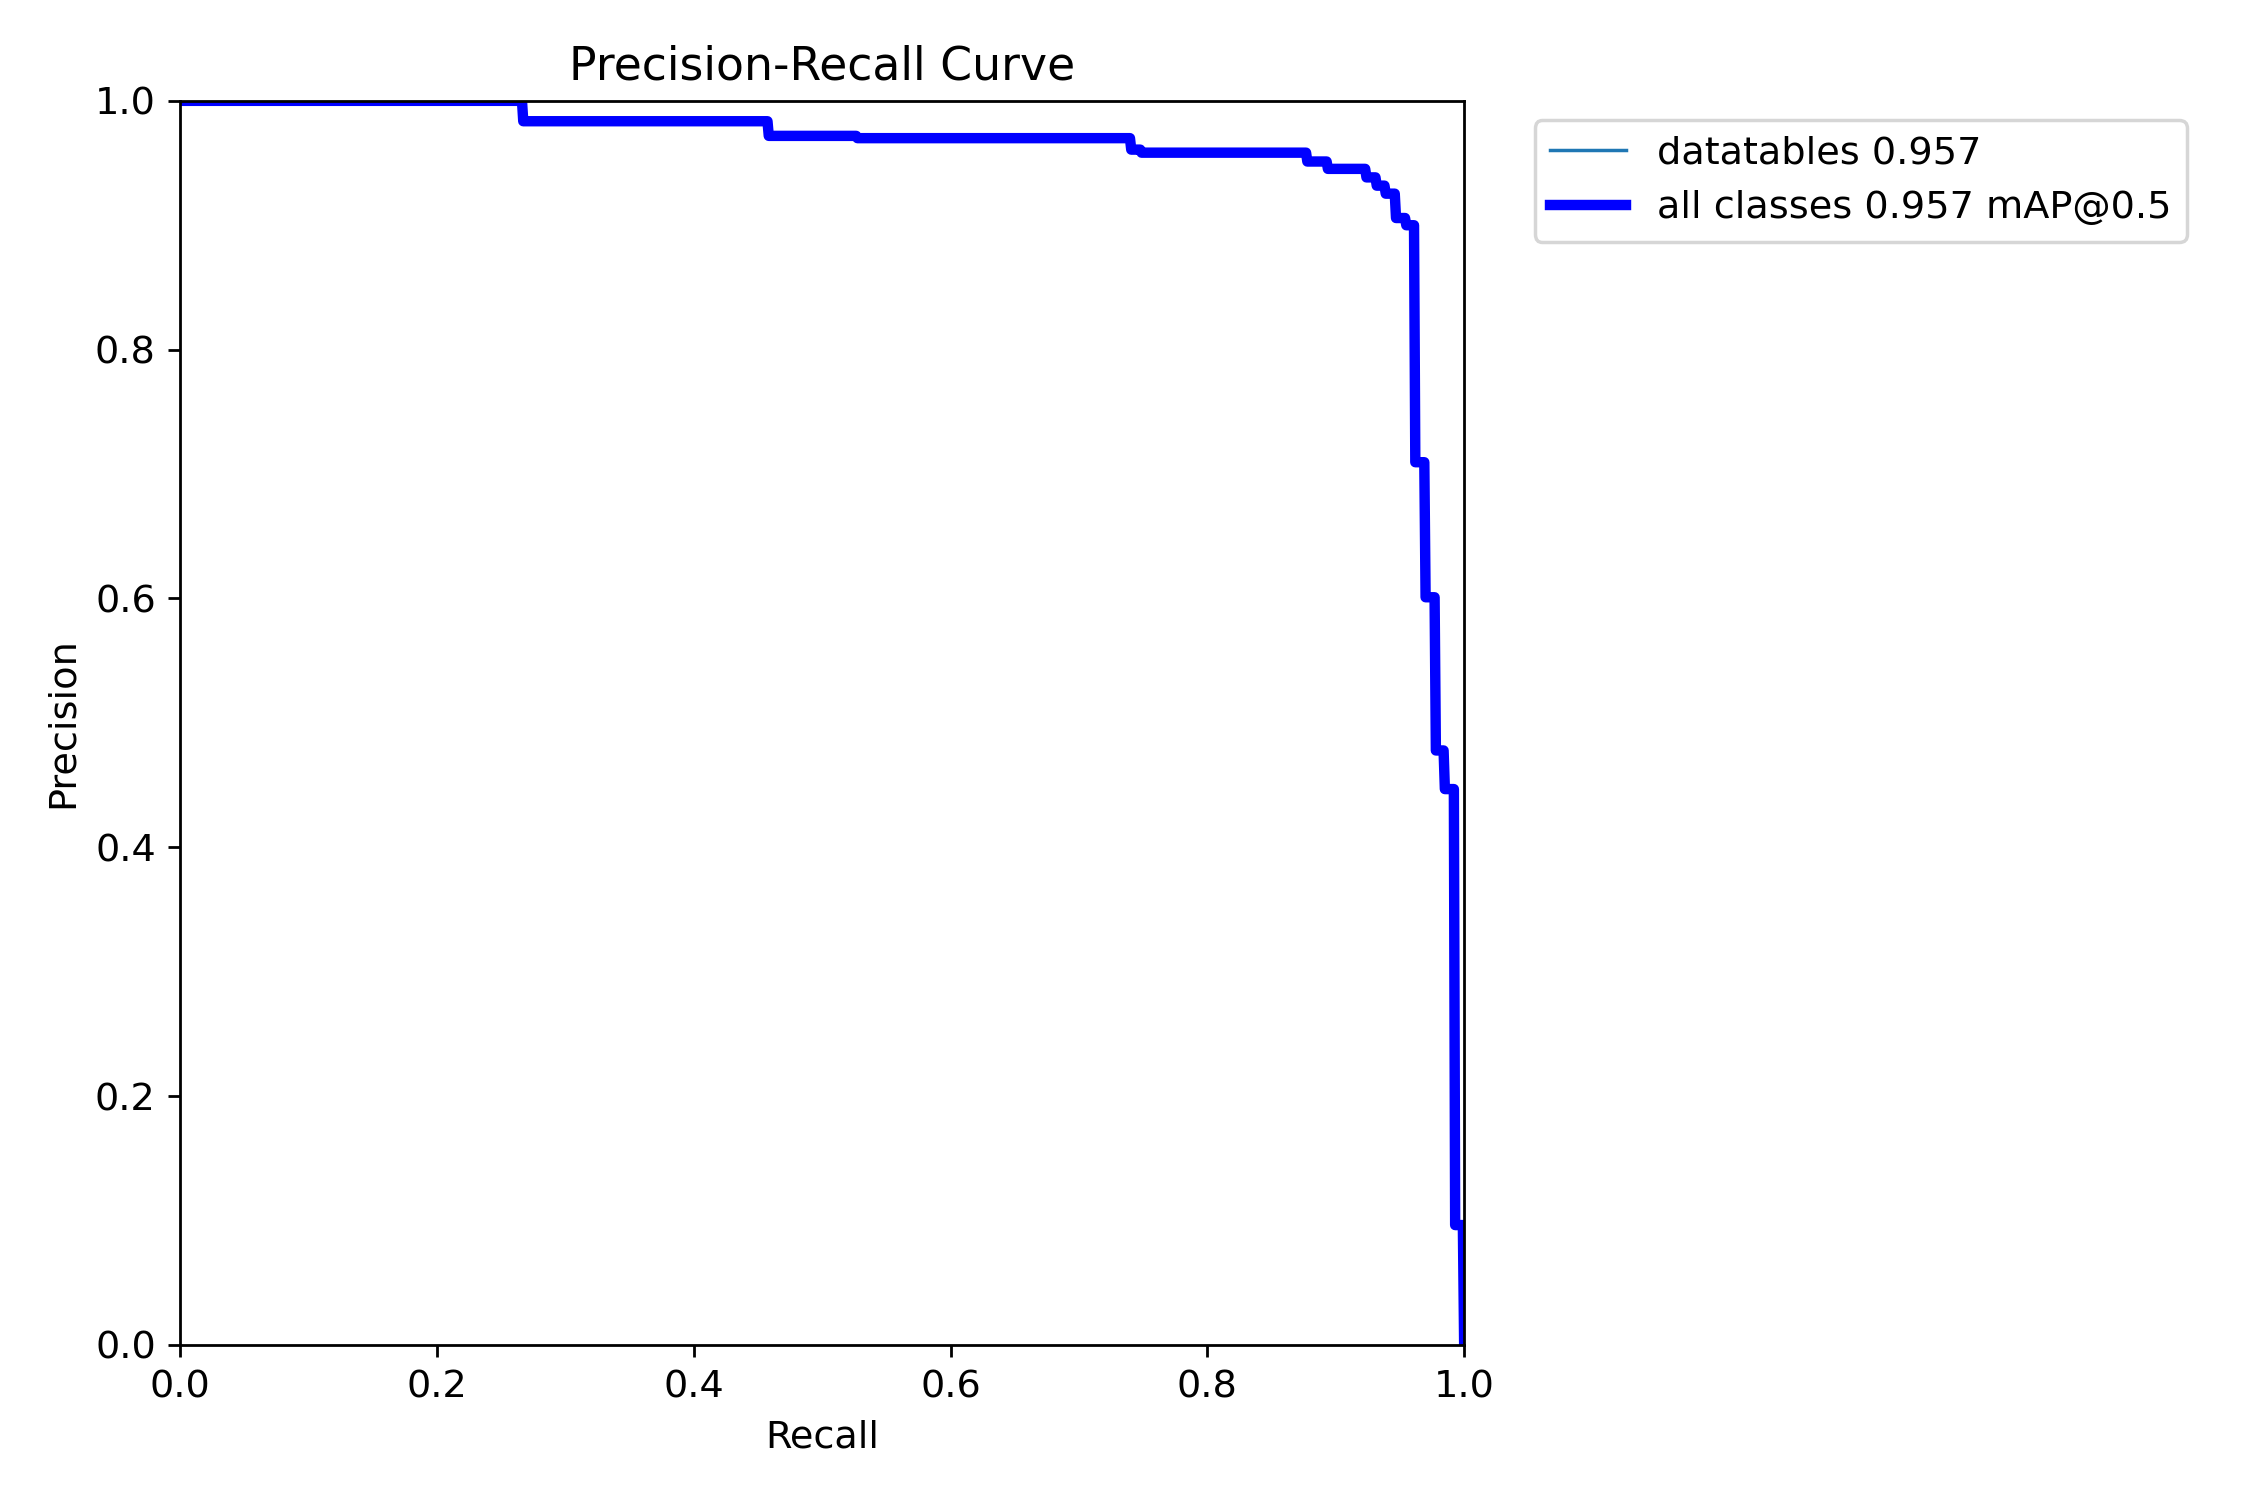

In [79]:
display.Image("/content/yolov5/yolov5/runs/val/exp13/PR_curve.png", width=600)

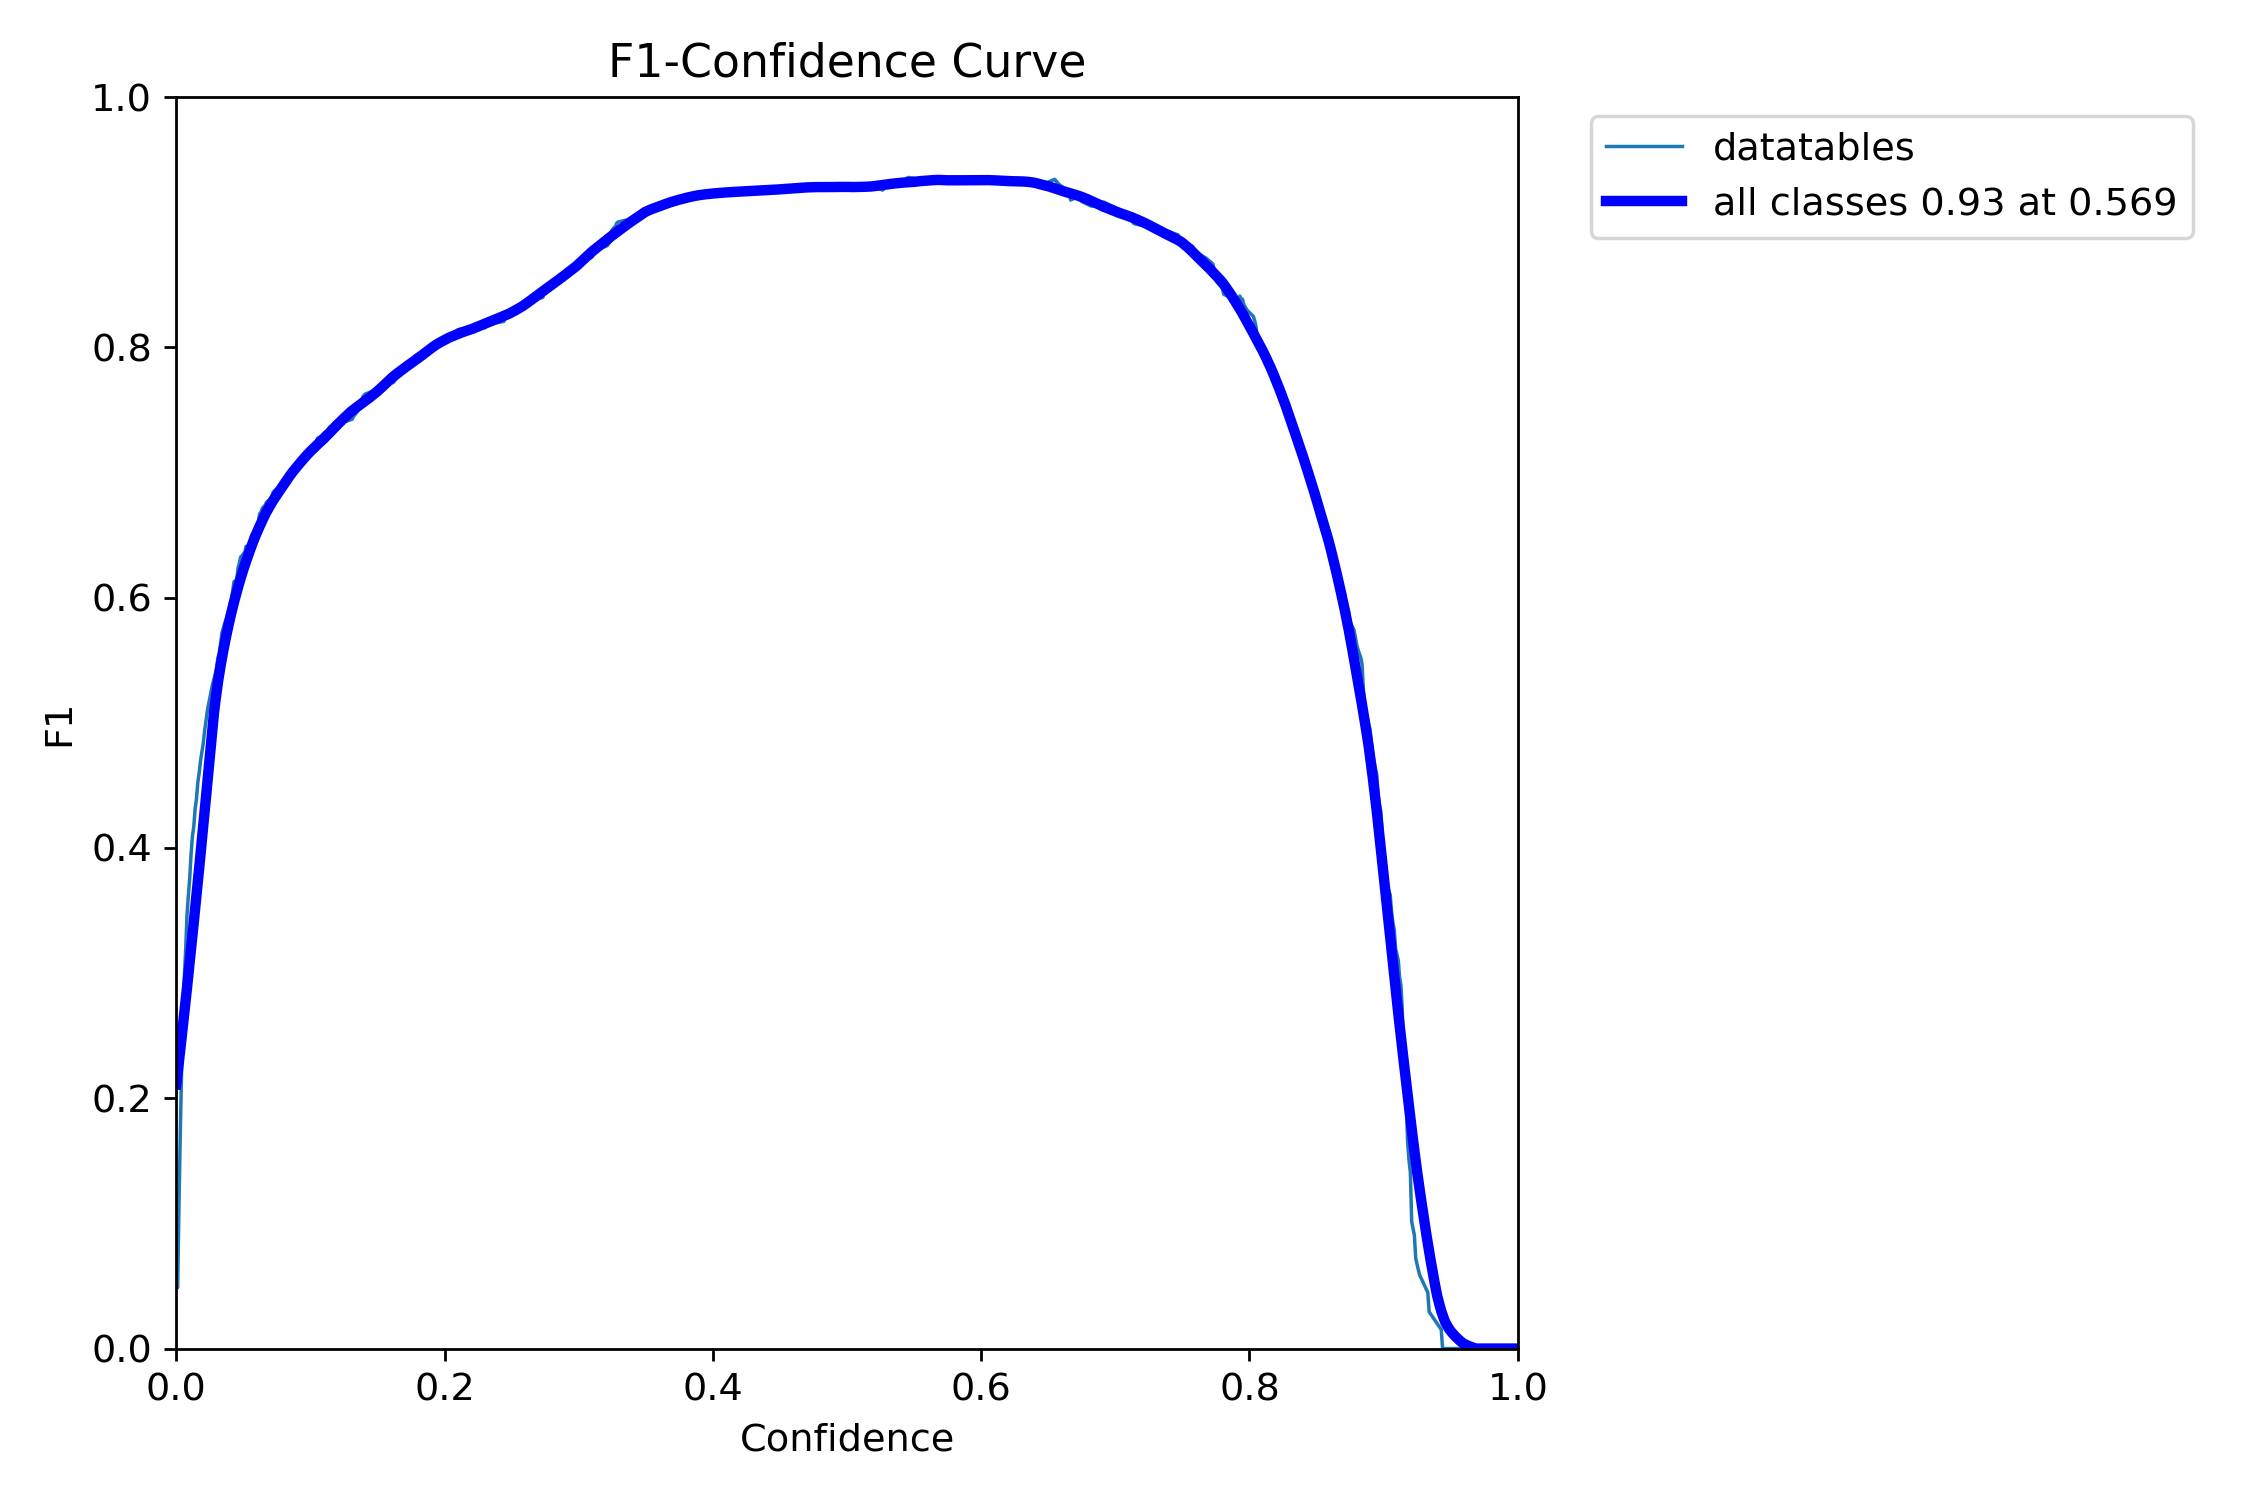

In [78]:
display.Image("/content/yolov5/yolov5/runs/val/exp13/F1_curve.png", width=600)

In [68]:
import random

# Choose a random image from the test set
test_image_dir = '/content/dataset/images/test'
img_filename = random.choice(os.listdir(test_image_dir))
img_path = os.path.join(test_image_dir, img_filename)
print(f"Selected image: {img_path}")

Selected image: /content/dataset/images/test/cTDaR_t10487.jpg


In [75]:
baseline_weights = '/content/yolov5/runs/train/yolo_model/weights/best.pt'
finetuned_weights = '/content/yolov5/runs/train/fine_tuned_model/weights/best.pt'

# Load models
baseline_model = torch.hub.load('ultralytics/yolov5', 'custom', path=baseline_weights, trust_repo=True)
finetuned_model = torch.hub.load('ultralytics/yolov5', 'custom', path=finetuned_weights, trust_repo=True)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-14 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)



Exception: [Errno 2] No such file or directory: '/content/yolov5/runs/train/yolo_model/weights/best.pt'. Cache may be out of date, try `force_reload=True` or see https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading for help.

In [ ]:
import matplotlib.pyplot as plt

# Run inference
baseline_results = baseline_model(img_path)
finetuned_results = finetuned_model(img_path)

# Render results (in-place modification of images)
baseline_img = baseline_results.render()[0]
finetuned_img = finetuned_results.render()[0]

# Plot predictions side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(baseline_img)
axs[0].set_title("Baseline YOLOv5")
axs[0].axis('off')

axs[1].imshow(finetuned_img)
axs[1].set_title("Fine-Tuned YOLOv5")
axs[1].axis('off')

plt.tight_layout()
plt.show()
